

# Objective

Investigate the effect of lockdown measures on economy. To identify economic activity we consider data sets such as electricity consumption and heavy truck toll movement data. As trucks are mainly used to transport goods their movement data helps in estimating the current economic activity

**Assumptions:**

* We consider all data specific to Germany/Berlin

* We consider electricity consumption data as a proxy indicator of economic activity


**Data used**

* Oxford Stringency Index - https://github.com/OxCGRT/covid-policy-tracker

* Apple Transit mobility - https://covid19.apple.com/mobility

* Berlin air temperature - https://mesonet.agron.iastate.edu/ASOS/

* Electricity consumption - Actual load data - https://transparency.entsoe.eu/load-domain/r2/totalLoadR2/show

* Truck toll data - Germany - https://www.destatis.de/DE/Themen/Branchen-Unternehmen/Industrie-Verarbeitendes-Gewerbe/Tabellen/Lkw-Maut-Fahrleistungsindex-Daten.xlsx?__blob=publicationFile


**Steps taken**

* Prepare the dataset. Consolidate above mentioned data into a single dataframe

* Build a causal model to estimate the effect of stringency measures on energy consumption

* Build a causal model to estimate the effect of stringency measures on truck toll movement

In [ ]:
from project_lib import Project
from sqlalchemy import create_engine
import sqlalchemy
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from sklearn.metrics import silhouette_score
from functools import reduce
import requests
import io
import seaborn as sbs
import datetime

try:
    import graphviz
except:
    !pip install graphviz
    import graphviz
try:
    import pydotplus
except:
    !pip install pydotplus
    
from IPython.display import display

import networkx as nx
try:
    import pydot
except:
    !pip install pydot

try:
    from dowhy import CausalModel
except:
    #!pip install sympy
    !pip install -I dowhy
    from dowhy import CausalModel
    
import warnings
warnings.filterwarnings('ignore')
    
%matplotlib inline

**Data Preparation**

In [2]:
project = Project.access()
Emergent_Db2_Warehouse_credentials = project.get_connection(name="db2 Warehouse ealuser")

sqla_url= "db2+ibm_db://" + Emergent_Db2_Warehouse_credentials['username']+ ':' + Emergent_Db2_Warehouse_credentials['password'] + "@"+ Emergent_Db2_Warehouse_credentials['host'] + ":50001/BLUDB;Security=ssl;"

#sqlalchemy
engine = create_engine(sqla_url, pool_size=10, max_overflow=20)
conn = engine.connect()
#engine.table_names()

Clustering of power consumption data:
    
    We have the power consumption data with a frequency of 1 hour for the year 2020. Using the raw data might be overwhelming for the causal model and the model might fail to identify the pattern in power consumption. So we cluster the data and use the cluster centers for the causal analysis.
    
    From the silhouette score plot, we see that the Kmeans with 3 clusters has the highest score suggesting an industrial pattern in power consumption

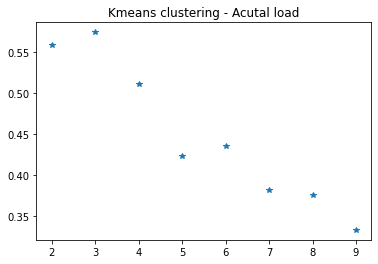

In [3]:
# Apple Transit mobility
df_apple_mob = pd.read_sql('select * from apple_transit_mobility;',conn)
df_apple_mob.index = pd.to_datetime(df_apple_mob['Timestamp'])
df_apple_mob_de = df_apple_mob[df_apple_mob['region']=='Berlin']

# Oxford Stringency index
df_stringency = pd.read_sql('select * from oxford_stringency_index',conn)
df_stringency_de = df_stringency[df_stringency['countryname']=='Germany']
df_stringency_de.index = pd.to_datetime(df_stringency_de['date'].astype(str))

# Berlin air temperature
r=requests.get('https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?station=EDDB&data=tmpc&year1=2020&month1=1&day1=1&year2=2020&month2=12&day2=7&tz=Etc%2FUTC&format=onlycomma&latlon=no&missing=M&trace=T&direct=no&report_type=1&report_type=2')
df_airtemp_be = pd.read_csv(io.BytesIO(r.content))
df_airtemp_be.index = pd.to_datetime(df_airtemp_be['valid'].values)
df_airtemp_be.drop(['station','valid'],axis=1,inplace=True)
df_airtemp_be = df_airtemp_be.resample('1D').median()

# Electricity consumption - Actual load data Germany
df_energy = pd.read_sql('select * from power_consumption', conn)
df_energy.index = pd.to_datetime(df_energy['load_date'].values)
df_energy.drop(['load_date','country'],axis=1,inplace=True)

#Energy consumption as it corresponds to human activity should show some sort of clustering behaviour.
# Consider the energy consumption data only until end of October 2020
df_energy_2020 = df_energy[(df_energy.index>pd.to_datetime('2019-12-31'))&(df_energy.index<pd.to_datetime('2020-11-1'))]

_X = df_energy_2020.replace(np.nan,0).values
scores = []
for n in range(2,10):
    res = KMeans(n).fit_predict(_X)
    scores.append(silhouette_score(_X,res))
plt.plot(range(2,10),scores,'*')
plt.title("Kmeans clustering - Acutal load")
plt.show()

# Use the 3 cluster centres as a representative of actual load data
_res = KMeans(3).fit_transform(_X)
df_energy_2020_fitted = pd.DataFrame(_res)
df_energy_2020_fitted.index = df_energy_2020.index
df_energy_2020_fitted.columns = ['energycc1','energycc2','energycc3']

# Truck toll data
df_lkw_movement = pd.read_excel("https://www.destatis.de/DE/Themen/Branchen-Unternehmen/Industrie-Verarbeitendes-Gewerbe/Tabellen/Lkw-Maut-Fahrleistungsindex-Daten.xlsx?__blob=publicationFile"
                       ,sheet_name="Daten",skiprows=5)
df_lkw_movement.index = pd.to_datetime(df_lkw_movement['Datum'])
df_lkw_movement.drop(['Datum'],axis=1,inplace=True)
df_lkw_movement_2020 = df_lkw_movement[df_lkw_movement.index>pd.to_datetime('2019-12-31')]
df_lkw_movement_2020.rename({'unbereinigt':'Truck_toll_movement_raw','Kalender- und saisonbereinigt (KSB)':'Truck_toll_movement_season_adj'},axis=1,inplace=True)

dfs = [df_apple_mob_de,df_stringency_de,df_airtemp_be,df_energy_2020_fitted,df_lkw_movement_2020]
df_final = reduce(lambda left,right: pd.merge(left,right,left_index=True,right_index=True,how='inner'), dfs)
df_final['weekday']=df_final.index.dayofweek.values



Raw time series nature of the data has to be removed by preprocessing the data so that it doesn't violate the assumption that the all rows of the data are sampled i.i.d. from some distribution. So, we include additional columns such as is_weekend, is_winter, is_spring, is_summer, is_autumn

Reference: https://github.com/microsoft/dowhy/issues/174

In [4]:
df_final['is_weekend'] = np.where((df_final.index.weekday == 5)|(df_final.index.weekday == 6),1,0)
df_final['is_winter'] = np.where((df_final.index.month==12)|(df_final.index.month<=2),1,0)
df_final['is_spring'] = np.where((df_final.index.month>=3)&(df_final.index.month<=5),1,0)
df_final['is_summer'] = np.where((df_final.index.month>=6)&(df_final.index.month<=8),1,0)
df_final['is_autumn'] = np.where((df_final.index.month>=9)&(df_final.index.month<=11),1,0)
#df_final['mobility_1'] = df_final['mobility'].shift()
#df_final['stringency_1'] = df_final['stringencyindex'].shift()

In [5]:
df_final = df_final[df_final.index<datetime.datetime(2020,11,1)]

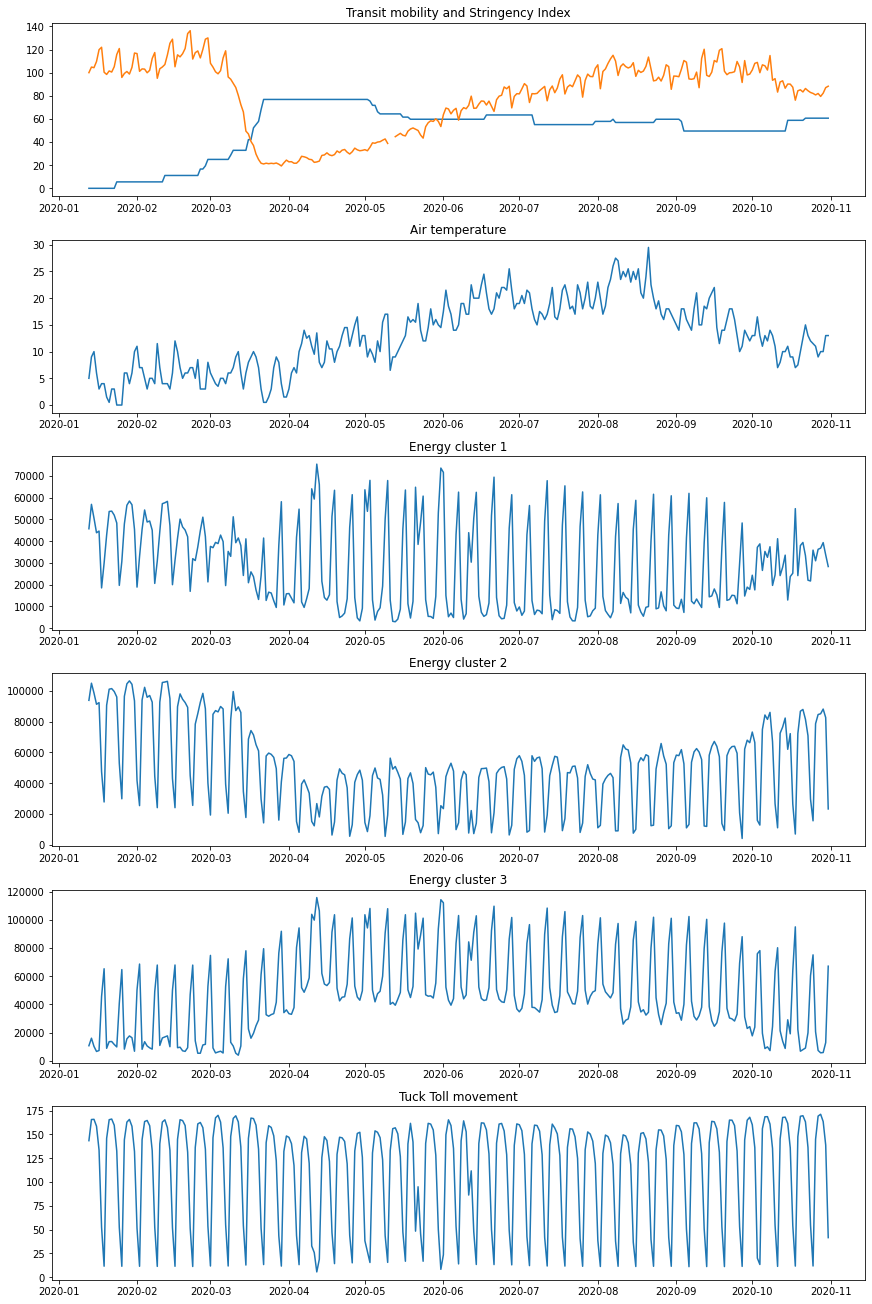

In [11]:
fig,axs = plt.subplots(nrows=6,ncols=1,figsize=(12,18),constrained_layout=True)
axs[0].plot(df_final['stringencyindex'])
axs[0].plot(df_final['mobility'])
axs[0].set_title("Transit mobility and Stringency Index")
axs[1].plot(df_final['tmpc'])
axs[1].set_title("Air temperature")
axs[2].plot(df_final['energycc1'])
axs[2].set_title("Energy cluster 1")
axs[3].plot(df_final['energycc2'])
axs[3].set_title("Energy cluster 2")
axs[4].plot(df_final['energycc3'])
axs[4].set_title("Energy cluster 3")
axs[5].plot(df_final['Truck_toll_movement_raw'])
axs[5].set_title("Tuck Toll movement")
plt.show()

In [7]:
df_final.tail()

,Timestamp,mobility,region,countryname,countrycode,regionname,regioncode,jurisdiction,date,c1_school closing,...,Truck_toll_movement_raw,Truck_toll_movement_season_adj,gleitender 7-Tage-Durchschnitt KSB,Veränderung KSB gegenüber Vortag in Prozent,weekday,is_weekend,is_winter,is_spring,is_summer,is_autumn
2020-10-27,2020-10-27,82.00,Berlin,Germany,DEU,None,None,NAT_TOTAL,20201027,1.0,...,169.2,113.7,114.6,1.9,1,0,0,0,0,1
2020-10-28,2020-10-28,79.45,Berlin,Germany,DEU,None,None,NAT_TOTAL,20201028,1.0,...,171.1,113.2,116.3,-0.4,2,0,0,0,0,1
2020-10-29,2020-10-29,82.26,Berlin,Germany,DEU,None,None,NAT_TOTAL,20201029,1.0,...,163.5,113.7,118.5,0.4,3,0,0,0,0,1
2020-10-30,2020-10-30,87.06,Berlin,Germany,DEU,None,None,NAT_TOTAL,20201030,1.0,...,138.8,122.0,119.4,7.3,4,0,0,0,0,1
2020-10-31,2020-10-31,88.29,Berlin,Germany,DEU,None,None,NAT_TOTAL,20201031,1.0,...,41.6,126.4,119.5,3.6,5,1,0,0,0,1


In [8]:
df_final.to_csv("/project_data/data_asset/dowhy_economic_data.csv")

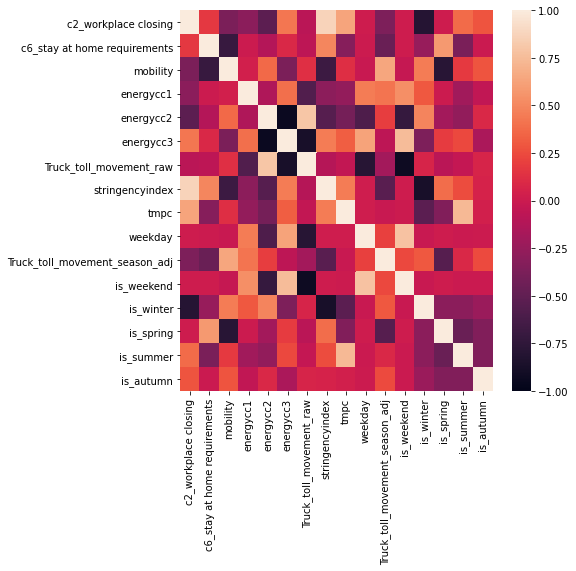

In [10]:
df_final_de_corr = df_final[['c2_workplace closing','c6_stay at home requirements','mobility','energycc1','energycc2','energycc3','Truck_toll_movement_raw','stringencyindex','tmpc',
                             'weekday','Truck_toll_movement_season_adj','is_weekend','is_winter','is_spring','is_summer','is_autumn']].corr()

#df_final_de_corr
plt.figure(figsize=(7,7))
sbs.heatmap(df_final_de_corr, vmax=1,vmin=-1)
plt.show()

**Hypothesis testing**

#### Hypothesis I

Estimate the effect of stringency measures on energycluster1

Consider Stringencyindex, Energy clusters, toll data corrected for seasonal effects, air temperature

**Determining edges mainly using linear correlation metrics**

mobility --> energycc2
mobility --> energycc3
stringencyindex --> mobility
stringencyindex --> energycc2
stringencyindex --> energycc3
tmpc --> energycc2
tmpc --> energycc3
is_weekend --> energycc1
is_weekend --> energycc2
is_weekend --> energycc3
is_weekend --> Truck_toll_movement_raw
is_spring --> mobility


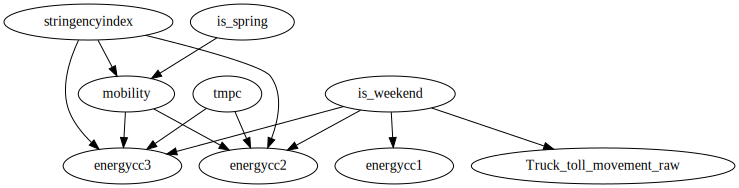

In [12]:
node_names = df_final_de_corr.columns
causes = ['mobility','stringencyindex','tmpc','is_weekend','is_spring','is_summer','is_autumn']
effects = ['mobility','energycc1', 'energycc2', 'energycc3','Truck_toll_movement_raw']
corr_graph_filename='prunedcausal-raw_extendedfeats_corr.dot'

corr_causal_graph = nx.DiGraph()    
corr_causal_graph.add_nodes_from(node_names)

used_nodes = []
for _node1 in causes:
    for _node2 in effects:
        if _node1 != _node2:
            if (abs(df_final_de_corr[_node1][_node2])>0.3):# & ([_node2,_node1] not in causal_graph.edges):
                print(_node1,'-->',_node2)
                corr_causal_graph.add_edge(_node1,_node2)
                used_nodes.extend([_node1,_node2])

used_nodes_set = set(used_nodes)
unused_nodes = list(set(node_names).difference(set(used_nodes_set)))

corr_causal_graph.remove_nodes_from(unused_nodes)
#causal_graph.add_edge("U",'stringencyindex')
#causal_graph.add_edge("U","energycc3")

nx.drawing.nx_pydot.write_dot(corr_causal_graph,corr_graph_filename)

with open(corr_graph_filename) as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)


**Combining the results from correlation analysis and domain knowledge**

* We consider only one of the energy clusters

* Seasonal effect is taken into consideration

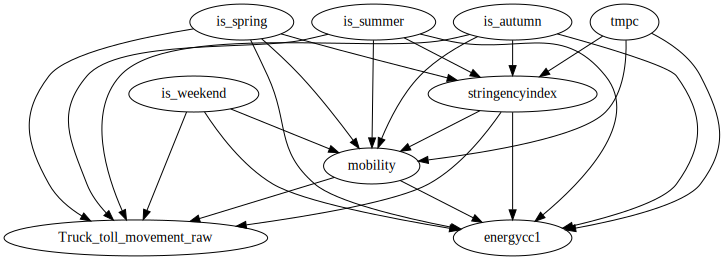

In [14]:
combined_causal_graph = nx.DiGraph()
combined_causal_graph.add_edge('is_weekend','mobility')
#combined_causal_graph.add_edge('is_winter','mobility')
combined_causal_graph.add_edge('is_spring','mobility')
combined_causal_graph.add_edge('is_summer','mobility')
combined_causal_graph.add_edge('is_autumn','mobility')
combined_causal_graph.add_edge('is_weekend','energycc1')
#combined_causal_graph.add_edge('is_winter','energycc1')
combined_causal_graph.add_edge('is_spring','energycc1')
combined_causal_graph.add_edge('is_summer','energycc1')
combined_causal_graph.add_edge('is_autumn','energycc1')
combined_causal_graph.add_edge('is_weekend','Truck_toll_movement_raw')
#combined_causal_graph.add_edge('is_winter','Truck_toll_movement_raw')
combined_causal_graph.add_edge('is_spring','Truck_toll_movement_raw')
combined_causal_graph.add_edge('is_summer','Truck_toll_movement_raw')
combined_causal_graph.add_edge('is_autumn','Truck_toll_movement_raw')
#combined_causal_graph.add_edge('is_winter','stringencyindex')
combined_causal_graph.add_edge('is_spring','stringencyindex')
combined_causal_graph.add_edge('is_summer','stringencyindex')
combined_causal_graph.add_edge('is_autumn','stringencyindex')
#combined_causal_graph.add_edge('mobility_1','mobility')
#combined_causal_graph.add_edge('mobility_1','stringencyindex')
#combined_causal_graph.add_edge('stringency_1','mobility')
#combined_causal_graph.add_edge('stringency_1','stringencyindex')
combined_causal_graph.add_edge('stringencyindex','mobility')
combined_causal_graph.add_edge('stringencyindex','energycc1')
combined_causal_graph.add_edge('stringencyindex','Truck_toll_movement_raw')
combined_causal_graph.add_edge('mobility','energycc1')
combined_causal_graph.add_edge('mobility','Truck_toll_movement_raw')
combined_causal_graph.add_edge('tmpc','mobility')
combined_causal_graph.add_edge('tmpc','energycc1')
combined_causal_graph.add_edge('tmpc','stringencyindex')


combined_graph_filename='prunedcausal-raw_extendedfeats_combined.dot'
nx.drawing.nx_pydot.write_dot(combined_causal_graph,combined_graph_filename)

with open(combined_graph_filename) as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [15]:
G = nx.drawing.nx_pydot.read_dot(combined_graph_filename)

model = CausalModel(data=df_final[list(G.nodes())].dropna().reset_index(drop=True),treatment=['stringencyindex'],outcome=['energycc1'],graph=combined_graph_filename,proceed_when_unidentifiable=True)
print(model)

estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(estimand)

estimate = model.estimate_effect(estimand,method_name="backdoor1.linear_regression")
print(estimate)


ERROR:dowhy.causal_graph:Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot...
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['stringencyindex'] on outcome ['energycc1']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:['mobility']
INFO:dowhy.causal_identifier:All common causes are observed. Causal effect can be identified.
INFO:dowhy.causal_identifier:All common causes are observed. Causal effect can be identified.


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
        d                                                                     
──────────────────(Expectation(energycc1|is_weekend,tmpc,is_autumn,is_spring,i
d[stringencyindex]                                                            

          
s_summer))
          
Estimand assumption 1, Unconfoundedness: If U→{stringencyindex} and U→energycc1 then P(energycc1|stringencyindex,is_weekend,tmpc,is_autumn,is_spring,is_summer,U) = P(energycc1|stringencyindex,is_weekend,tmpc,is_autumn,is_spring,is_summer)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
        d                                                                    
──────────────────(Expectation(energycc1|tmpc,is_autumn,is_spring,is_summer))
d[stringencyindex]                                                           
Estimand assumption 1, Unconfoundedness: If U→{stringencyindex} and U→energycc1 then 

INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
        d                                                                     
──────────────────(Expectation(energycc1|is_weekend,tmpc,is_autumn,is_spring,i
d[stringencyindex]                                                            

          
s_summer))
          
Estimand assumption 1, Unconfoundedness: If U→{stringencyindex} and U→energycc1 then P(energycc1|stringencyindex,is_weekend,tmpc,is_autumn,is_spring,is_summer,U) = P(energycc1|stringencyindex,is_weekend,tmpc,is_autumn,is_spring,is_summer)

## Realized estimand
b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
Target units: ate

## Estimate
Mean value: -152.03013558491512
### Conditional Estimates
__categorical__is_weekend
(-0.001, 1.0]   -152.030136
dtype: float64


In [16]:
model.do(12,identified_estimand=estimand,method_name="backdoor1.linear_regression")

INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


['backdoor1', 'linear_regression']


**Refute the estimate**

Refutation methods help in validating the causal effect estimate

Placebo Treatment: 

What happens to the estimated causal effect when we replace the true treatment variable with an independent random variable? (Hint: the effect should go to zero)

In [17]:
ref = model.refute_estimate(estimand=estimand, estimate=estimate,method_name='placebo_treatment_refuter')
print(ref)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of Random Data treatment
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: energycc1~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: energycc1~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: energycc1~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.ca

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: energycc1~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: energycc1~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: energycc1~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_esti

INFO:dowhy.causal_estimator:b: energycc1~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: energycc1~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: energycc1~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: energycc1~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causa

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: energycc1~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: energycc1~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: energycc1~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a N

Refute: Use a Placebo Treatment
Estimated effect:-152.03013558491512
New effect:1.1641532182693481e-10
p value:0.0



Add Random Common Cause: 

Does the estimation method change its estimate after we add an independent random variable as a common cause to the dataset? (Hint: It should not)

In [18]:
ref3 = model.refute_estimate(estimand=estimand, estimate=estimate,method_name='random_common_cause')
print(ref3)

INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+w_random+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


Refute: Add a Random Common Cause
Estimated effect:-152.03013558491512
New effect:-152.32961644775787



Data Subsets Validation: 

Does the estimated effect change significantly when we replace the given dataset with a randomly selected subset? (Hint: It should not)

In [19]:
ref2 = model.refute_estimate(estimand=estimand, estimate=estimate,method_name='data_subset_refuter')
print(ref2)

INFO:dowhy.causal_refuters.data_subset_refuter:Refutation over 0.8 simulated datasets of size 232.8 each
INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+

INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: energycc1~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy

Refute: Use a subset of data
Estimated effect:-152.03013558491512
New effect:-159.44401392887357
p value:0.37



In [20]:
print("Common Causes:",model._common_causes)
print("Effect Modifiers:",model._effect_modifiers)
print("Instruments:",model._instruments)
print("Outcome:",model._outcome)
print("Treatment:",model._treatment)

Common Causes: ['tmpc', 'is_autumn', 'is_spring', 'U', 'is_summer']
Effect Modifiers: ['is_weekend']
Instruments: []
Outcome: ['energycc1']
Treatment: ['stringencyindex']


**Hypothesis II**

Investigate the effect of stringency measures on truck toll movement

We use the same causal graph but change the outcome variable

In [21]:
G2 = nx.drawing.nx_pydot.read_dot(combined_graph_filename)

model2 = CausalModel(data=df_final[list(G2.nodes())].dropna().reset_index(drop=True),treatment=['stringencyindex'],outcome=['Truck_toll_movement_raw'],graph=combined_graph_filename,proceed_when_unidentifiable=True)
print(model2)

estimand2 = model2.identify_effect(proceed_when_unidentifiable=True)
print(estimand2)

estimate2 = model2.estimate_effect(estimand2,method_name="backdoor.linear_regression")
print(estimate2)


ERROR:dowhy.causal_graph:Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot...
INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['stringencyindex'] on outcome ['Truck_toll_movement_raw']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]
INFO:dowhy.causal_identifier:Frontdoor variables for treatment and outcome:['mobility']
INFO:dowhy.causal_identifier:All common causes are observed. Causal effect can be identified.
INFO:dowhy.causal_identifier:All common causes are observed. Causal effect can be identified.
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tmpc+is_autum

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor1 (Default)
Estimand expression:
        d                                                                     
──────────────────(Expectation(Truck_toll_movement_raw|is_weekend,tmpc,is_autu
d[stringencyindex]                                                            

                        
mn,is_spring,is_summer))
                        
Estimand assumption 1, Unconfoundedness: If U→{stringencyindex} and U→Truck_toll_movement_raw then P(Truck_toll_movement_raw|stringencyindex,is_weekend,tmpc,is_autumn,is_spring,is_summer,U) = P(Truck_toll_movement_raw|stringencyindex,is_weekend,tmpc,is_autumn,is_spring,is_summer)

### Estimand : 2
Estimand name: backdoor2
Estimand expression:
        d                                                                     
──────────────────(Expectation(Truck_toll_movement_raw|tmpc,is_autumn,is_sprin
d[stringencyindex]                                                           

In [22]:
ref21 = model2.refute_estimate(estimand=estimand2, estimate=estimate2,method_name='placebo_treatment_refuter')
print(ref21)

INFO:dowhy.causal_refuters.placebo_treatment_refuter:Refutation over 100 simulated datasets of Random Data treatment
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_re

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_re

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_refuters.placebo_treatment_refuter:Using a Normal Distribution with Mean:0 and Variance:0
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~placebo+is_weekend+tmpc+is_autumn+is_spring+is_summer+placebo*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_re

Refute: Use a Placebo Treatment
Estimated effect:-0.3521648837716498
New effect:5.115907697472721e-13
p value:0.0



In [23]:
ref22 = model2.refute_estimate(estimand=estimand2, estimate=estimate2,method_name='random_common_cause')
print(ref22)

INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+w_random+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator


Refute: Add a Random Common Cause
Estimated effect:-0.3521648837716498
New effect:-0.3499122373494572



In [24]:
ref23 = model2.refute_estimate(estimand=estimand2, estimate=estimate2,method_name='data_subset_refuter')
print(ref23)

INFO:dowhy.causal_refuters.data_subset_refuter:Refutation over 0.8 simulated datasets of size 232.8 each
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Truck_toll_movem

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tm

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tmpc+is_autumn+is_spring+is_summer+stringencyindex*is_weekend
INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: Truck_toll_movement_raw~stringencyindex+is_weekend+tm

Refute: Use a subset of data
Estimated effect:-0.3521648837716498
New effect:-0.34708545464433965
p value:0.49



In [25]:
print("Common Causes:",model2._common_causes)
print("Effect Modifiers:",model2._effect_modifiers)
print("Instruments:",model2._instruments)
print("Outcome:",model2._outcome)
print("Treatment:",model2._treatment)

Common Causes: ['tmpc', 'is_autumn', 'is_spring', 'U', 'is_summer']
Effect Modifiers: ['is_weekend']
Instruments: []
Outcome: ['Truck_toll_movement_raw']
Treatment: ['stringencyindex']


**Author**

* Shri Nishanth Rajendran - AI Development Specialist, R² Data Labs, Rolls Royce

This notebook is based on the work done by Deepak Srinivasan

Special thanks to Deepak Srinivasan and Alvaro Corrales Cano
